## ## This code creates control variates based on 2nd order polynomials and compare the error in estimating E_f(h(X)) using them with a classical Monte Carlo method 

## Sources:

## "Zero Variance Differential Geometric Markov Chain Monte Carlo Algorithms", Papamarkou and al, 2014

In [12]:
# scientific computing library
import numpy as np
# visualization tools
import matplotlib.pyplot as plt

In [14]:
# m draws from the distribution we are interested in, m<=100
#returns a 1d-array
def draws(m, samples):#samples is a 1d-array
    return(samples[:m])    
    
#function z; only works in the case of standard normal distribution; defined in Papamarkou's article
def z(x):
    return(x/2)    
    
#function w which takes as argument a 1D-array; returns a 2d-array; defined in Papamarkou's article
def w(L):
    return(np.array([z(L), L*z(L)-0.5]))  

#"true" mean of f(X)
def true_mean(f):
    return(np.mean([np.mean(f(np.random.normal(0, 1, 100))) for i in range (1000)]))

#error based on a classic Monte Carlo Method and using  m samples
#returns a scalar; np.log10 needs or not to be added depending on the cases
def ErrorFunction( true_mean, samples, f):
    return((abs(np.sum(f(samples))/len(samples)-true_mean)))

#coefficient estimator a_hat estimated using the first n samples; defined in Papamarkou's article
    #returns a 2d-array of size dim parameter \times 1
def a_hat(n, f, samples):
    samples_a_hat=draws(n, samples)
    #Sample variance matrix of z
    Var=(w(samples_a_hat)-np.mean(w(samples_a_hat), axis=1).reshape(2, 1).dot(np.ones((1,len(samples_a_hat))))).dot((w(samples_a_hat)-np.mean(w(samples_a_hat), axis=1).reshape(2, 1).dot(np.ones((1,len(samples_a_hat))))).T)/(n-1)
    #Covariance matrix of the target function and z
    Cov= np.sum(np.row_stack((f(samples_a_hat)-np.mean(f(samples_a_hat)),f(samples_a_hat)-np.mean(f(samples_a_hat))))*(w(samples_a_hat)-np.mean(w(samples_a_hat), axis=1).reshape(2, 1).dot(np.ones((1,len(samples_a_hat))))), axis=1)/(n-1)
    return(-np.linalg.inv(Var).dot(Cov))

#New function built with the control variate (2nd degree polynome P); defined in Papamarkou's article by g_tilde
def newf(x, n, f, samples):
    return(f(x)+a_hat(n, f, samples).T.dot(w(x))) 

## Plot the function h, the distribution against which we integrate and the control variate 

In [19]:
###PLots of the functions we want to integrate, the control variate and the distribution, in the case of a 1D 
#integration space
def plot_functions(f):
    # x-axis variable
    x = np.linspace(-5, 5)
    np.random.seed(123)
    samples= np.random.normal(0, 1, 100)
    # y-axis variable
    y_f1 = f(x)
    y_newf1=-a_hat(50, f, samples).T.dot(w(x))
    y_distri=(1/(np.sqrt(2 * np.pi)) *np.exp( - x**2 / 2 ))
    # visualize
    axes = plt.gca()
    axes.set_ylim([-1.5,1.5])
    plt.plot(x, y_f1, label="f1")
    plt.plot(x, y_newf1, label="Control variate")
    plt.plot(x, y_distri, label="pdf", linestyle="-.")
    plt.title("Plot for f(x)=x")
    plt.legend();
    return(plt.show())

## Functions to plot the (expectation of ) the Error or logError

In [21]:
##Plots of the error against the number of Monte Carlo samples
###    n=30 and n=50 (Number of samples used for assessing the value of a_hat)
def visu(g, true_mean):
    # x-axis variable
    x1 = np.arange(start=1, stop=101, step=1) 
    x2 = np.arange(start=31, stop=101, step=1)
    x3 = np.arange(start=51, stop=101, step=1)
    # y-axis variable
    y1= np.zeros(len(x1))
    y2= np.zeros(len(x1))
    y3= np.zeros(len(x1)) 
    np.random.seed(123)
    samples= np.random.normal(0, 1, 100)
    for i in range (0, len(x1)):
        y1[i] = ErrorFunction(x1[i], true_mean, samples, g)
        y2[i] = ErrorFunction(x1[i], true_mean, samples, f=lambda x:newf(x, 30, g, samples))
        y3[i] = ErrorFunction(x1[i], true_mean, samples, f=lambda x:newf(x, 50, g, samples))        
    # visualize
    plt.plot(x1, y1, label= "Classic Monte Carlo method")
    plt.plot(x2, y2[30:], label= "n="+ str(30))
    plt.plot(x3, y3[50:], label= "n="+ str(50))    
    plt.title("Plot for f=x^3")
    plt.xlabel("m=Number of Monte Carlo Samples")
    plt.ylabel("log|Error|")
    plt.legend();
    return(plt.show())
    
#Plots of the expectation of the error against the number of Monte Carlo samples’  
#   N number of replicates, n: number of samples used  for assessing the value of a_hat   #N >=n     
def visu_expectation_error(g, true_mean, N):
    x1 = np.arange(start=1, stop=101, step=10) 
    x2 = np.arange(start=31, stop=101, step=10)
    x3 = np.arange(start=51, stop=101, step=10)  
    # y-axis variable
    y1=np.zeros((N, len(x1)))
    y2=np.zeros((N, len(x2)))
    y3=np.zeros((N, len(x3)))
    for i in range(N):
        samples= np.random.normal(0, 1, 100) 
        for j in range (0, len(x1)):
            y1[i, j] = ErrorFunction( true_mean, samples[:x1[j]], g)   
        for j in range (0, len(x2)):
            y2[i, j] = ErrorFunction( true_mean, samples[30:x2[j]], f=lambda x:newf(x, 30, g, samples))
        for j in range (0, len(x3)):
            y3[i, j] = ErrorFunction( true_mean, samples[50:x3[j]], f=lambda x:newf(x, 50, g, samples))
        # making sure that the length of the two variables match
        # visualize
    plt.plot(x1, 1/N*np.sum(y1, axis=0), label= "Classic Monte Carlo method", linestyle="-",  marker="o",linewidth=1) 
    plt.plot(x2, 1/N*np.sum(y2, axis=0), label= "n="+ str(30), linestyle="-",  marker="o",linewidth=1) 
    plt.plot(x3, 1/N*np.sum(y3, axis=0), label= "n="+ str(50), linestyle="-",  marker="o",linewidth=1) 
    plt.title("Plot for h(x)=x")
    plt.xlabel("m=Number of Monte Carlo Samples")
    plt.ylabel("E|Error|")
    plt.legend();
    return(plt.show()) 

## functions we want to integrate with respect to the probability density f  

In [17]:
def h1(x):
    return(x)

def h2(x):
    return(x**2)

def h3(x):
    return(x**3)

## Exemple when the integration space is 1D

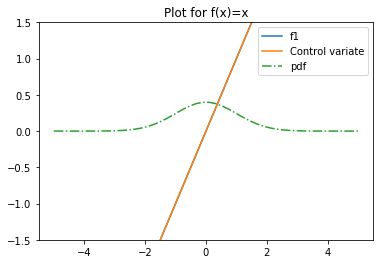

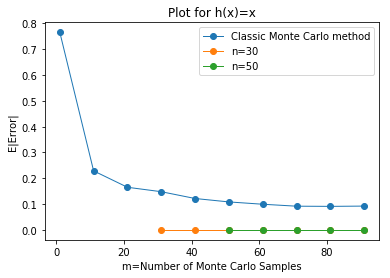

In [22]:
#Choice of the mean of the multivariate normal distribution
mean = np.array([0])#1d-array
#Choice of the variance of the multivariate normal distribution
cov = np.array([[1]])#2d-array

plot_functions(h1)
visu_expectation_error(h1, 0, 100)